In [1]:
from aad import B1530Lib
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

def plot_result(data, V='VA', I='IB', title = None):
    plt.figure(figsize=(8,10))
    ax1=plt.subplot(311)
    ax2=plt.subplot(312,sharex=ax1)
    ax3=plt.subplot(313,sharex=ax1)

    if title is not None:
        ax1.set_title(title)
    
    ax1.plot(data.time*1e6,data[V])
    ax1.plot(data.time*1e6,data[V], 'r.')
    ax1.set_ylabel('$' + V + '$ (V)')
    ax1.set_xlabel('Time ($\mu s$)')
    ax1.grid()
    
    ax2.plot(data.time*1e6, abs(data[I])*1e3)
    ax2.plot(data.time*1e6,abs(data[I])*1e3, 'r.')
    ax2.set_ylabel('$' + I + '$ (mA)')
    ax2.set_xlabel('Time ($\mu s$)')
    ymin, ymax = ax2.get_ylim()
    ax2.set_ylim(0, ymax * 1.5)
    ax2.grid()

    ax3.plot(data.time*1e6, (abs(data[V] / data[I])), 'bo')
    ax3.set_ylabel('Resistance ($\log{\Omega}$)')
    ax3.set_yscale('log')
    ax3.set_xlabel('Time ($\mu s$)')
    ymin, ymax = ax3.get_ylim()
    ax3.set_ylim(ymin * 0.99, ymax * 1.01)
    ax3.grid()

    plt.tight_layout()
    

In [2]:
B1530Lib.print_devices()
b = B1530Lib.B1530()

ASRL3::INSTR
ASRL4::INSTR
ASRL6::INSTR
GPIB0::INTFC
GPIB0::18::INSTR


In [3]:
av_t            = 1e-5
sample_interval = 1e-5

b.chan[2].name = 'VA'
b.chan[2].wave = B1530Lib.Pulse(voltage=2.5, interval=10e-5, edges=1e-7, length=10e-5).repeat(1)
# Will choose the best range for the voltage of the wave + will ignore the measures when the voltage is changing
b.chan[2].measure_self(average_time=av_t, sample_interval=sample_interval)

b.chan[1].name = 'IB'
# Will ignore the measures when the voltage is changing and when it is at 0V
b.chan[1].meas = b.chan[2].measure(mode='current', range='10mA', average_time=av_t, sample_interval=sample_interval, ignore_gnd=True)

b.configure()

In [4]:
b.exec()

<IPython.core.display.Javascript object>


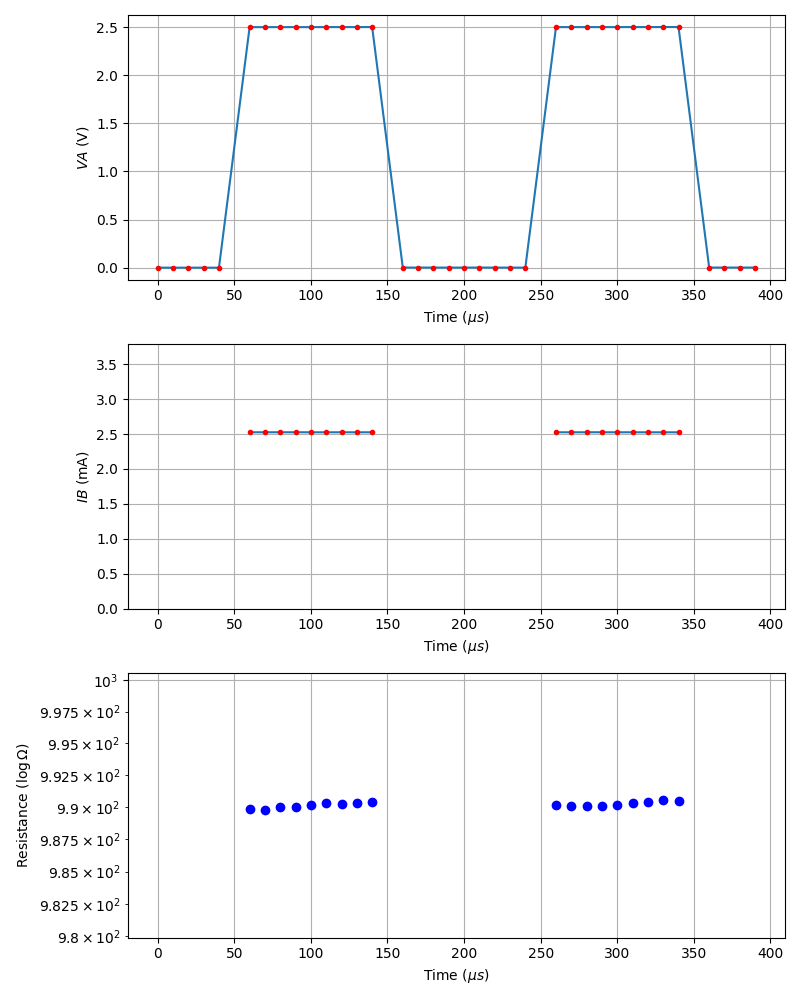

In [5]:
plot_result(b.get_result('VA', 'IB'))

A resistor of 1 kΩ is measured: OK  

---  

Now I-V characteristic of a 2N7000 MOSFET:

In [6]:
# Create step waveform
step_length = 1e-4
step_jump   = 1e-5

sample_interval = (step_length) / 10
av_t = sample_interval

pattern = []
for i in range(10):
    pattern.extend([[step_jump, 1 + i * 0.05], [step_length, 1 + i * 0.05]])
pattern.extend([[step_jump, 0], [step_length / 2, 0]])

b.reset_configuration()

b.chan[2].name = 'V_{DS}'
b.chan[2].wave = B1530Lib.Waveform([[0, 5]]) # DC voltage, 5V

b.chan[3].name = 'V_{GS}'
b.chan[3].wave = B1530Lib.Waveform(pattern)
b.chan[3].measure_self(average_time=av_t, sample_interval=sample_interval)

b.chan[1].name = 'I_D'
b.chan[1].meas = b.chan[3].measure(mode='current', range='10mA', average_time=av_t, sample_interval=sample_interval, ignore_gnd=True)

b.configure()

In [9]:
b.exec()

<IPython.core.display.Javascript object>


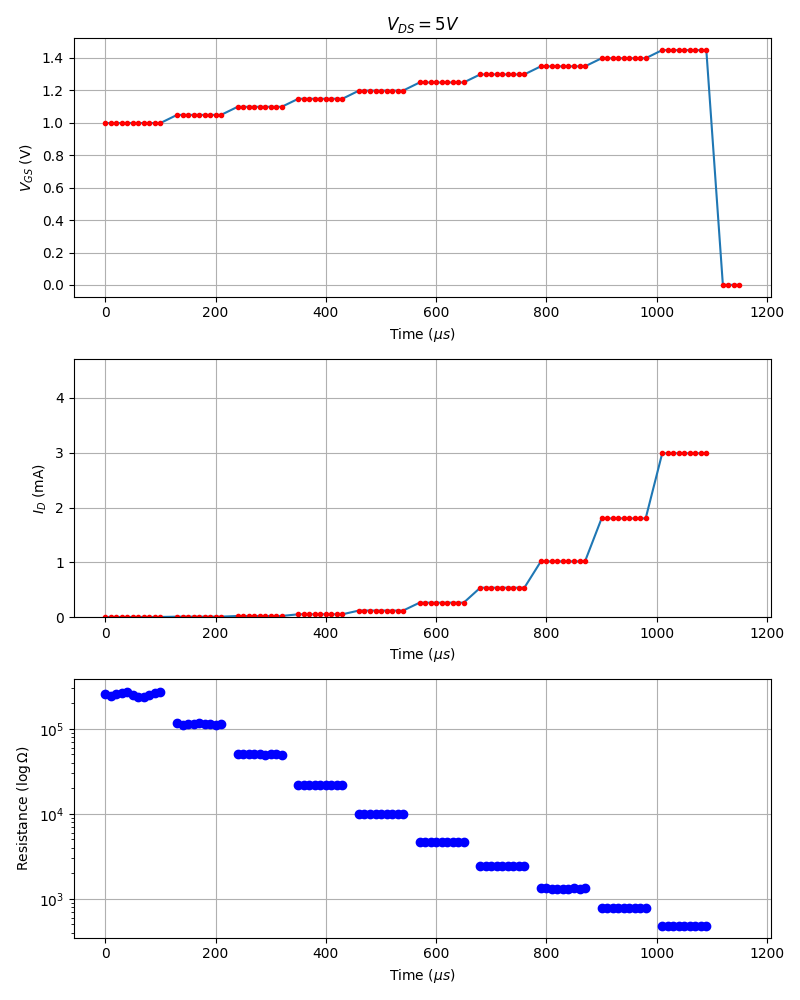

In [10]:
plot_result(b.get_result('V_{GS}', 'I_D'), V='V_{GS}', I='I_D', title='$V_{DS} = 5V$')

<IPython.core.display.Javascript object>


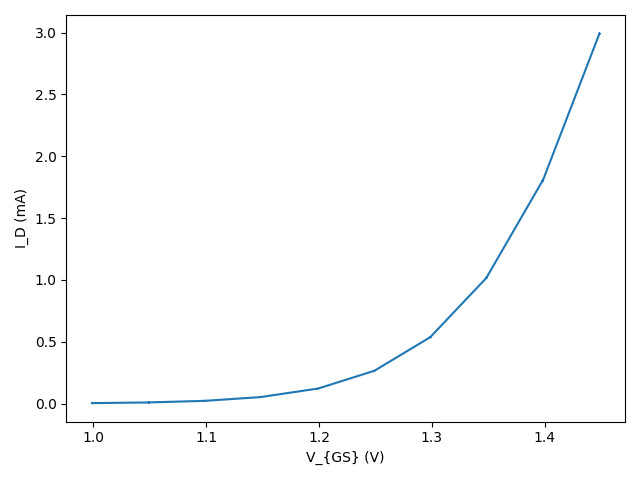

In [14]:
data = b.get_result('V_{GS}', 'I_D')
plt.plot(data['V_{GS}'], abs(data.I_D) * 1e3)
plt.xlabel('V_{GS} (V)')
plt.ylabel('I_D (mA)')
plt.tight_layout()